## Accessing MTBS data using the Planetary Computer STAC API

This notebook provides an example of accessing Monitoring Trends in Burn Severity (MTBS) Mosiacs for CONUS and Alaska using the Planetary Computer API. The data is stored in annual cloud optimized GeoTIFF files.

MTBS data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on MTBS data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop! 

Complete documentation for this dataset is available on the [Planetary Computer data catalog](https://planetarycomputer.microsoft.com/dataset/mtbs).

### Environment Setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
from pystac_client import Client
from pystac.extensions.projection import ProjectionExtension as proj
from shapely.geometry import shape
from shapely.ops import transform

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import planetary_computer as pc
import pyproj
import xarray as xr

### Querying the dataset

The MTBS data on Azure is available for the CONUS or Alaska regions on an annual basis from 1984 to 2018. Let's query the Planetary Computer to find data items within the `mbts` collection.



In [2]:
carr_fire_aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.73925781250001, 40.50857873259441],
            [-122.33139038085936, 40.50857873259441],
            [-122.33139038085936, 40.891715295571046],
            [-122.73925781250001, 40.891715295571046],
            [-122.73925781250001, 40.50857873259441],
        ]
    ],
}

In [3]:
# TODO: staging
catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")
mtbs = catalog.search(collections=["mtbs"], intersects=carr_fire_aoi)

items = [pc.sign(item) for item in mtbs.get_all_items()]
print(f"Returned {len(items)} Items:", *items[:10] + ["..."], sep="\n")

Returned 35 Items:
<Item id=mtbs_severity_conus_2018_30m>
<Item id=mtbs_severity_conus_2017_30m>
<Item id=mtbs_severity_conus_2016_30m>
<Item id=mtbs_severity_conus_2015_30m>
<Item id=mtbs_severity_conus_2014_30m>
<Item id=mtbs_severity_conus_2013_30m>
<Item id=mtbs_severity_conus_2012_30m>
<Item id=mtbs_severity_conus_2011_30m>
<Item id=mtbs_severity_conus_2010_30m>
<Item id=mtbs_severity_conus_2009_30m>
...


While only reading metadata from the STAC API response we can check the footprint shape of this data, and what assets it contains. Based on the size, we'll want to only read a subsection of the underlying file. 

In [4]:
# TODO: pc.sign
item = items[0]
print("Footprint shape:", proj.ext(item).shape)
print("Assets:", ", ".join(item.assets))

Footprint shape: [70357, 69612]
Assets: metadata, burn-severity


### Read item asset with xarray

Open the asset file on blob storage using `rioxarray`. We'll select the data asset `burn-severity` which has the URL for the underlying GeoTIFF.

In [5]:
da = xr.open_rasterio(
    item.assets["burn-severity"].href, chunks={"x": 2560, "y": 2560}
).squeeze()
da

<xarray.DataArray (y: 70357, x: 69612)>
dask.array<getitem, shape=(70357, 69612), dtype=uint8, chunksize=(2560, 2560), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 3.096e+06 3.096e+06 3.096e+06 ... 9.854e+05 9.854e+05
  * x        (x) float64 -2.298e+06 -2.298e+06 ... -2.102e+05 -2.101e+05
Attributes:
    transform:           (30.0, 0.0, -2298465.0, 0.0, -30.0, 3096045.0)
    crs:                 +proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45...
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (0.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

### Plot one fire event

We can select a subset of the data to make a plot over our single fire event. To select from the larger DataArray, we'll transform our original GeoJSON area of iterest to the CRS of the dataset and use the bounds to slice the array.

In [6]:
%%time
aoi_poly = shape(carr_fire_aoi)
from_crs = pyproj.CRS("EPSG:4326")
to_crs = pyproj.CRS.from_proj4(da.crs)

project = pyproj.Transformer.from_crs(from_crs, to_crs, always_xy=True).transform
utm_poly = transform(project, aoi_poly)
minx, miny, maxx, maxy = utm_poly.bounds

fire_da = da.sel(y=slice(maxy, miny), x=slice(minx, maxx))

CPU times: user 107 ms, sys: 7.44 ms, total: 114 ms
Wall time: 120 ms


Up to this point, we haven't actually read any data yet, but by plotting we'll trigger the read and see out results.

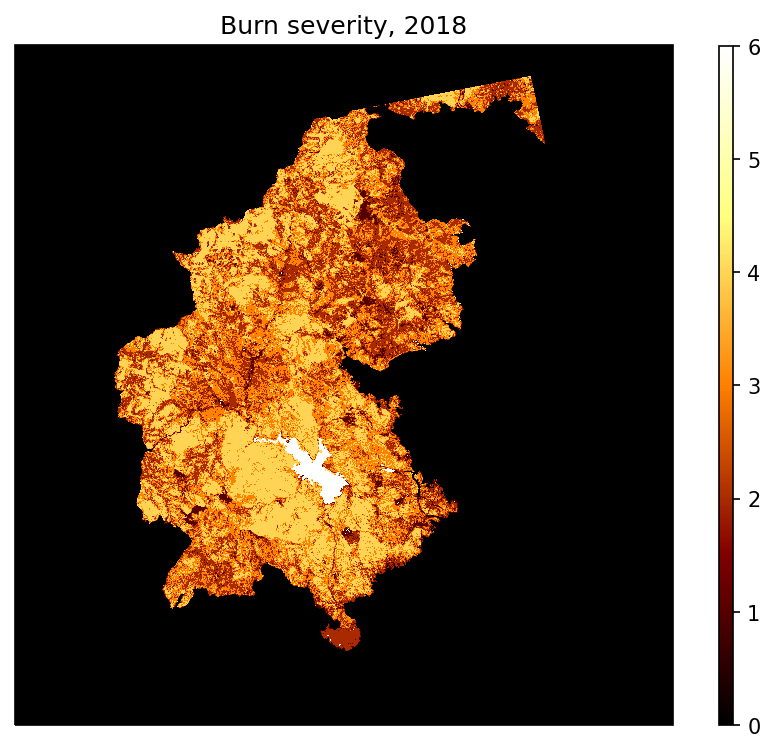

In [7]:
fig, ax = plt.subplots(
    figsize=(8, 6),
    dpi=150,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    frameon=False,
)
ax.patch.set_facecolor("black")
fire_da.plot(
    ax=ax, transform=ccrs.AlbersEqualArea(), cbar_kwargs={"aspect": 50}, cmap="afmhot"
)
plt.title("Burn severity, 2018")
plt.show()